# 죽산보 데이터 분석

## 주요 내용

- 죽산보 데이터 기초 통계 확인

## 데이터 정보

* 죽산보 수질 데이터(Jugsanbo.xlsx)   
    * 2012-2022년  
    * 시간 단위 수집 데이터
* 죽산보 유량 데이터(Jugsanbo_flow.xlsx)
    * 2012-2022년
    * 10분 단위 수집 데이터

## 필수 모듈 임포트

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error

**데이터프레임 설정**

In [3]:
pd.set_option('display.max_columns', None) # 모든 특성이 잘리지 않도록 함.

**matplotlib 한글 설정**

In [4]:
# !pip install koreanize_matplotlib
# import koreanize_matplotlib

## 죽산보 데이터 불러오기

**디렉토리 관리 객체**

In [5]:
from pathlib import Path

**데이터 저장소**

In [6]:
from pathlib import Path

base_path = Path("../data")

**보 이름**

- 영산강에 설치된 승촌보와 죽산보 중에 죽산보 데이터만 활용

In [7]:
weirs = ['죽산보']

### 수질/기상 데이터 불러오기

**데이터 연도**

- 2012년부터 2023년도 사이의 데이터
- **시간 단위**의 데이터
- 죽산보 수량 데이터는 10분 단위의 데이터이며 다른 형식의 엑셀 파일에 저장되어 있어서 다른 방식으로 불러와야 함.

In [8]:
years = range(2012, 2024)

**디렉토리에서 원하는 파일목록 리스트로 가져오기**

- 16개 보의 기상 데이터와 수질 데이터가 연도별로 수집되어 있음.

In [9]:
import os

def file_arr(path):
    arr = []
    fileList = os.listdir(path)
    fileList.sort()
    
    for f in fileList:
        # 임시 파일 제외
        if f.find('~$') != -1:
            continue
        if f.find('zNex~$hare') != -1:
            continue
        if f.find('.xlsx') != -1:
            arr.append(path / f)
    return arr

- 16개 보의 수질 데이터를 담고 있는 연도별 파일 목록

In [10]:
file_arr(base_path / '16개 보_수질 데이터')

[PosixPath('../data/16개 보_수질 데이터/수질_2012년도(7~12월).xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2013년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2014년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2015년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2016년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2017년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2018년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2019년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2020년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2021년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2022년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2023년도(1~8월).xlsx')]

- 16개 보의 기상 데이터를 담고 있는 연도별 파일 목록

In [11]:
file_arr(base_path / '16개 보_기상 데이터')

[PosixPath('../data/16개 보_기상 데이터/기상_2012년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2013년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2014년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2015년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2016년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2017년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2018년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2019년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2020년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2021년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2022년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2023년도.xlsx')]

**연도별 수질 데이터 불러오기**

- 16개 보 수질/기상 데이터를 객체를 값으로 갖는 사전으로 불러오는 함수

In [12]:
from collections import defaultdict

def data_merge(dirName):
    ndriver_weir_dict = defaultdict(dict)
    fileList = file_arr(base_path / dirName)
    
    for f in fileList:
        if '20' in f.name and '년' in f.name:
            year = f.name[f.name.find('20'): f.name.find('20') + 4]
        else:
            year = f'20{f.name[-7:-5]}'

        print(f'===== {year} 시작 =====')
            
        # pd.ExcelFile() 함수를 이용하여 엑셀 파일 정보와 함께 시트별로 데이터 불러옴
        with pd.ExcelFile(f) as xls:
            for sheetName in xls.sheet_names:
                if '(' in sheetName:
                    idx = sheetName.index('(')
                    weir = sheetName[:idx]
                elif '·' in sheetName:
                    weir = sheetName.replace('·', '')
                else:
                    weir = sheetName

                if weir in weirs:
                    ndriver_weir_dict[weir][year] = pd.read_excel(xls, sheet_name = sheetName)
                    print(f'{weir}', end = ', ')
            print()

    return ndriver_weir_dict

- 죽산보 수질 데이터 불러오기

In [13]:
jsb_wq = data_merge('16개 보_수질 데이터')

===== 2012 시작 =====
죽산보, 
===== 2013 시작 =====
죽산보, 
===== 2014 시작 =====
죽산보, 
===== 2015 시작 =====
죽산보, 
===== 2016 시작 =====
죽산보, 
===== 2017 시작 =====
죽산보, 
===== 2018 시작 =====
죽산보, 
===== 2019 시작 =====
죽산보, 
===== 2020 시작 =====
죽산보, 
===== 2021 시작 =====
죽산보, 
===== 2022 시작 =====
죽산보, 
===== 2023 시작 =====
죽산보, 


In [14]:
jsb_wq.keys()

dict_keys(['죽산보'])

In [15]:
jsb_wq['죽산보'].keys()

dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'])

- 예제: 죽산보 2012년 수질 데이터

In [16]:
jsb_wq['죽산보']['2012']

,측정일(시),수온 (℃),수소이온농도,전기전도도 (μS/cm),용존산소 (mg/L),탁도 (NTU),총유기탄소 (mg/L),총질소 (mg/L),총인 (mg/L),클로로필-a (mg/㎥)
0,2012-07-01 00h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-07-01 01h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-07-01 02h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-07-01 03h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-07-01 04h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4411,2012-12-31 19h,3.2,6.8,271.0,12.2,1.9,1.9,NaN,NaN,11.9
4412,2012-12-31 20h,3.0,6.8,272.0,12.2,1.7,1.9,NaN,NaN,11.6
4413,2012-12-31 21h,3.2,6.8,272.0,12.3,6.4,1.9,NaN,NaN,11.6
4414,2012-12-31 22h,3.1,6.8,272.0,12.2,2.1,1.9,NaN,NaN,11.7


- 죽산보 기상 데이터 불러오기

In [17]:
jsb_weather = data_merge('16개 보_기상 데이터')

===== 2012 시작 =====
죽산보, 
===== 2013 시작 =====
죽산보, 
===== 2014 시작 =====
죽산보, 
===== 2015 시작 =====
죽산보, 
===== 2016 시작 =====
죽산보, 
===== 2017 시작 =====
죽산보, 
===== 2018 시작 =====
죽산보, 
===== 2019 시작 =====
죽산보, 
===== 2020 시작 =====
죽산보, 
===== 2021 시작 =====
죽산보, 
===== 2022 시작 =====
죽산보, 
===== 2023 시작 =====
죽산보, 


In [18]:
jsb_weather.keys()

dict_keys(['죽산보'])

In [19]:
jsb_weather['죽산보'].keys()

dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'])

- 예제: 죽산보 2012년 기상 데이터

In [20]:
jsb_weather['죽산보']['2012']

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위)
0,156,광주,2012-07-01 00:00:00,21.6,NaN,2.1,NaN,NaN,8.0,8.0
1,156,광주,2012-07-01 01:00:00,21.3,NaN,1.6,NaN,NaN,NaN,NaN
2,156,광주,2012-07-01 02:00:00,21.1,NaN,0.8,NaN,NaN,NaN,NaN
3,156,광주,2012-07-01 03:00:00,21.1,NaN,1.3,NaN,NaN,9.0,9.0
4,156,광주,2012-07-01 04:00:00,21.0,NaN,0.4,NaN,NaN,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...
4411,156,광주,2012-12-31 19:00:00,-2.3,NaN,2.5,NaN,NaN,6.0,6.0
4412,156,광주,2012-12-31 20:00:00,-2.7,NaN,1.8,NaN,NaN,7.0,7.0
4413,156,광주,2012-12-31 21:00:00,-2.9,0.2,0.6,NaN,NaN,6.0,6.0
4414,156,광주,2012-12-31 22:00:00,-3.4,NaN,0.1,NaN,NaN,NaN,NaN


**수질/기상 데이터 통합**

In [21]:
def merge_weir_df(weir):
    df_concat = pd.DataFrame()
    
    for year in years:
        df1 = jsb_wq[weir][str(year)]
        df2 = jsb_weather[weir][str(year)]
#         df3 = jsb_dflow[weir][str(year)]
        
        df1 = df1.astype({'측정일(시)': 'datetime64[ns]'})
        df2 = df2.astype({'일시': 'datetime64[ns]'}) 
#         df3 = df3.astype({'측정일(시)': 'datetime64[ns]'})
                                  
        df = pd.merge(df1, df2, left_on = '측정일(시)', right_on = '일시', how = 'left').drop(columns = '일시')
#         df = pd.merge(df, df3, how = 'left')
                                  
        df_concat = pd.concat([df_concat, df]).reset_index(drop = True)

    df_concat = df_concat.set_index('측정일(시)')
    return df_concat

In [22]:
jsb_df = merge_weir_df('죽산보')

jsb_df

,수온 (℃),수소이온농도,전기전도도 (μS/cm),용존산소 (mg/L),탁도 (NTU),총유기탄소 (mg/L),총질소 (mg/L),총인 (mg/L),클로로필-a (mg/㎥),지점,지점명,기온(°C),강수량(mm),풍속(m/s),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위)
측정일(시),,,,,,,,,,,,,,,,,,
2012-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.6,NaN,2.1,NaN,NaN,8.0,8.0
2012-07-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.3,NaN,1.6,NaN,NaN,NaN,NaN
2012-07-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.1,NaN,0.8,NaN,NaN,NaN,NaN
2012-07-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.1,NaN,1.3,NaN,NaN,9.0,9.0
2012-07-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.0,NaN,0.4,NaN,NaN,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31 19:00:00,25.1,6.5,115.0,6.8,33.1,3.2,1.790,NaN,5.0,156,광주,25.2,NaN,0.7,0.4,0.24,7.0,0.0
2023-08-31 20:00:00,24.9,6.5,117.0,6.9,33.1,3.1,1.786,NaN,5.0,156,광주,24.0,NaN,0.6,0.0,0.05,7.0,0.0
2023-08-31 21:00:00,24.8,6.4,119.0,6.8,31.8,3.2,1.753,NaN,5.1,156,광주,22.9,NaN,1.9,NaN,NaN,0.0,0.0


In [23]:
jsb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   수온 (℃)         83510 non-null  float64
 1   수소이온농도         83602 non-null  float64
 2   전기전도도 (μS/cm)  83518 non-null  float64
 3   용존산소 (mg/L)    82326 non-null  object 
 4   탁도 (NTU)       82651 non-null  float64
 5   총유기탄소 (mg/L)   77093 non-null  float64
 6   총질소 (mg/L)     75725 non-null  float64
 7   총인 (mg/L)      76715 non-null  float64
 8   클로로필-a (mg/㎥)  81256 non-null  float64
 9   지점             97896 non-null  int64  
 10  지점명            97896 non-null  object 
 11  기온(°C)         97884 non-null  float64
 12  강수량(mm)        10444 non-null  float64
 13  풍속(m/s)        97862 non-null  float64
 14  일조(hr)         53272 non-null  float64
 15  일사(MJ/m2)      53521 non-null  float64
 16  전운량(10분위)      86142 non-null  float64
 17  중하층운량(10분위)    

**참고**

- 2012년 7월 1일부터 2023년 8월 31일까지의 시간 데이터 수

In [24]:
len(pd.date_range('2012-07-01 00:00:00', '2023-08-31 23:00:00', freq = 'h'))

97896

### 수량 데이터 불러오기

- 죽산보 수량 데이터는 `'yeongsanriver_weir_dflow'` 디렉토리의 `'Jugsanbo_dflow.xlsx'` 파일에 있음.
- 연도별 데이터는 시트(sheet)로 구분됨.
- 수질/기상 데이터와는 달리 **10분 단위**의 데이터로 구성됨.

In [25]:
jsb_dflow_file = base_path / "yeongsanriver_weir_dflow" / "Jugsanbo_dflow.xlsx"

In [26]:
jsb_dflow_yearly = pd.read_excel(jsb_dflow_file, 
#                                  skiprows=0, 
                                 header=0, 
                                 sheet_name=None,
                                 na_values='ND',
#                                  parse_dates=[0]  # 시간 특성을 date time으로 파싱
                                )

In [27]:
jsb_dflow_yearly.keys()

dict_keys(['2012(7~12월)', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023(1~8월)'])

- 2012 수량 데이터

In [28]:
jsb_dflow_yearly['2012(7~12월)']

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2012.07.01 00:00,3.69,0.00,0.0,0.0
1,2012.07.01 00:10,3.70,0.00,0.0,0.0
2,2012.07.01 00:20,3.71,0.00,0.0,0.0
3,2012.07.01 00:30,3.70,0.00,0.0,0.0
4,2012.07.01 00:40,3.70,0.00,0.0,0.0
...,...,...,...,...,...
26491,2012.12.31 23:10,3.74,-1.68,42.0,42.0
26492,2012.12.31 23:20,3.74,-1.68,42.0,42.0
26493,2012.12.31 23:30,3.74,-1.68,42.0,42.0
26494,2012.12.31 23:40,3.74,-1.68,42.0,42.0


- 2013 수량 데이터

In [29]:
jsb_dflow_yearly['2013']

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013.01.01 00:00,3.74,-1.70,42.00,42.00
1,2013.01.01 00:10,3.74,-1.71,42.00,42.00
2,2013.01.01 00:20,3.74,-1.71,42.00,42.00
3,2013.01.01 00:30,3.74,-1.71,42.00,42.00
4,2013.01.01 00:40,3.74,-1.71,42.00,42.00
...,...,...,...,...,...
52555,2013.12.31 23:10,3.53,-1.18,17.33,17.30
52556,2013.12.31 23:20,3.53,-1.17,17.30,17.28
52557,2013.12.31 23:30,3.53,-1.17,17.29,17.29
52558,2013.12.31 23:40,3.53,-1.18,17.28,17.27


- 2023 수량 데이터

In [30]:
jsb_dflow_yearly['2023(1~8월)']

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2023.01.01 00:00,1.52,-1.48,10.35,10.34
1,2023.01.01 00:10,1.52,-1.48,10.38,10.37
2,2023.01.01 00:20,1.52,-1.47,10.38,10.42
3,2023.01.01 00:30,1.52,-1.47,10.41,10.44
4,2023.01.01 00:40,1.52,-1.47,10.42,10.39
...,...,...,...,...,...
34950,2023.08.31 23:10,1.52,-1.66,200.77,205.06
34951,2023.08.31 23:20,1.52,-1.61,202.82,205.03
34952,2023.08.31 23:30,1.52,-1.56,218.66,204.88
34953,2023.08.31 23:40,1.51,-1.55,193.46,204.63


**년도별 수량 데이터 통합**

년도별 데이터를 통합해서 하나의 데이터프레임으로 만드는 함수

In [31]:
def concat_yearly_data(yearly_df_dict):
    df_concat = pd.DataFrame()

    for year in list(yearly_df_dict.keys()):
        df_concat = pd.concat([df_concat, yearly_df_dict[year]])

    return df_concat

In [32]:
jsb_dflow_10 = concat_yearly_data(jsb_dflow_yearly)
jsb_dflow_10

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2012.07.01 00:00,3.69,0.00,0.00,0.00
1,2012.07.01 00:10,3.70,0.00,0.00,0.00
2,2012.07.01 00:20,3.71,0.00,0.00,0.00
3,2012.07.01 00:30,3.70,0.00,0.00,0.00
4,2012.07.01 00:40,3.70,0.00,0.00,0.00
...,...,...,...,...,...
34950,2023.08.31 23:10,1.52,-1.66,200.77,205.06
34951,2023.08.31 23:20,1.52,-1.61,202.82,205.03
34952,2023.08.31 23:30,1.52,-1.56,218.66,204.88
34953,2023.08.31 23:40,1.51,-1.55,193.46,204.63


In [33]:
jsb_dflow_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 587146 entries, 0 to 34954
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   시간           587146 non-null  object 
 1    상류수위(EL.m)  587146 non-null  float64
 2    하류수위(EL.m)  587146 non-null  float64
 3    유입량(㎥/s)    587146 non-null  float64
 4    방류량(㎥/s)    587146 non-null  float64
dtypes: float64(4), object(1)
memory usage: 26.9+ MB


**시간 특성 전처리**

- 2019년도 이후의 데이터에 시간이 `24:00`가 `00:00`과 함께 동시에 사용된 경우가 있음.
- 따라서 이런 데이터를 삭제해야 함.

In [34]:
mask = jsb_dflow_10['시간'].map(lambda x: '24:00' in x)
mask.sum()

103

In [35]:
jsb_dflow_10 = jsb_dflow_10.loc[~mask]
jsb_dflow_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 587043 entries, 0 to 34954
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   시간           587043 non-null  object 
 1    상류수위(EL.m)  587043 non-null  float64
 2    하류수위(EL.m)  587043 non-null  float64
 3    유입량(㎥/s)    587043 non-null  float64
 4    방류량(㎥/s)    587043 non-null  float64
dtypes: float64(4), object(1)
memory usage: 26.9+ MB


`'시간'` 특성을 `datatime` 자료형으로 변환한다.

In [36]:
jsb_dflow_10 = jsb_dflow_10.astype({'시간': 'datetime64[ns]'})
jsb_dflow_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 587043 entries, 0 to 34954
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   시간           587043 non-null  datetime64[ns]
 1    상류수위(EL.m)  587043 non-null  float64       
 2    하류수위(EL.m)  587043 non-null  float64       
 3    유입량(㎥/s)    587043 non-null  float64       
 4    방류량(㎥/s)    587043 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 26.9 MB


인덱스를 `'시간'` 특성으로 변경한 후에 정렬한다.

In [37]:
jsb_dflow_10 = jsb_dflow_10.set_index('시간')
jsb_dflow_10 = jsb_dflow_10.sort_index()
jsb_dflow_10

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
시간,,,,
2012-07-01 00:00:00,3.69,0.00,0.00,0.00
2012-07-01 00:10:00,3.70,0.00,0.00,0.00
2012-07-01 00:20:00,3.71,0.00,0.00,0.00
2012-07-01 00:30:00,3.70,0.00,0.00,0.00
2012-07-01 00:40:00,3.70,0.00,0.00,0.00
...,...,...,...,...
2023-08-31 23:10:00,1.52,-1.66,200.77,205.06
2023-08-31 23:20:00,1.52,-1.61,202.82,205.03
2023-08-31 23:30:00,1.52,-1.56,218.66,204.88


### 수량 데이터 통합

**10분 단위를 1시간 단위로 변경**  

먼저 시간별 평균값을 활용하여 1시간 단위 데이터로 변환한다.

In [38]:
jsb_dflow = jsb_dflow_10.resample("h").mean()
jsb_dflow

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
시간,,,,
2012-07-01 00:00:00,3.700000,0.000000,0.000000,0.000000
2012-07-01 01:00:00,3.706667,0.000000,0.000000,0.000000
2012-07-01 02:00:00,3.718333,0.000000,0.000000,0.000000
2012-07-01 03:00:00,3.723333,0.000000,0.000000,0.000000
2012-07-01 04:00:00,3.728333,0.000000,0.000000,0.000000
...,...,...,...,...
2023-08-31 19:00:00,1.520000,-0.758333,229.176667,202.258333
2023-08-31 20:00:00,1.530000,-0.990000,214.316667,206.406667
2023-08-31 21:00:00,1.530000,-1.431667,206.468333,206.518333


수질/기상 데이터와 날짜를 기준으로 통합한다.

In [39]:
jsb_data = jsb_df.join(jsb_dflow, how = 'left')

날짜를 기준으로 정렬한다.

In [40]:
jsb_data = jsb_data.sort_index()
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   수온 (℃)         83510 non-null  float64
 1   수소이온농도         83602 non-null  float64
 2   전기전도도 (μS/cm)  83518 non-null  float64
 3   용존산소 (mg/L)    82326 non-null  object 
 4   탁도 (NTU)       82651 non-null  float64
 5   총유기탄소 (mg/L)   77093 non-null  float64
 6   총질소 (mg/L)     75725 non-null  float64
 7   총인 (mg/L)      76715 non-null  float64
 8   클로로필-a (mg/㎥)  81256 non-null  float64
 9   지점             97896 non-null  int64  
 10  지점명            97896 non-null  object 
 11  기온(°C)         97884 non-null  float64
 12  강수량(mm)        10444 non-null  float64
 13  풍속(m/s)        97862 non-null  float64
 14  일조(hr)         53272 non-null  float64
 15  일사(MJ/m2)      53521 non-null  float64
 16  전운량(10분위)      86142 non-null  float64
 17  중하층운량(10분위)    

In [41]:
jsb_data.columns

Index(['수온 (℃)', '수소이온농도', '전기전도도 (μS/cm)', '용존산소 (mg/L)', '탁도 (NTU)',
       '총유기탄소 (mg/L)', '총질소 (mg/L)', '총인 (mg/L)', '클로로필-a (mg/㎥)', '지점', '지점명',
       '기온(°C)', '강수량(mm)', '풍속(m/s)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)',
       '중하층운량(10분위)', ' 상류수위(EL.m)', ' 하류수위(EL.m)', ' 유입량(㎥/s)', ' 방류량(㎥/s)'],
      dtype='object')

수량 특성 이름의 처음에 포함된 공백을 제거한다.

In [42]:
jsb_data.columns = [x.strip() for x in list(jsb_data.columns)]

In [43]:
jsb_data.columns

Index(['수온 (℃)', '수소이온농도', '전기전도도 (μS/cm)', '용존산소 (mg/L)', '탁도 (NTU)',
       '총유기탄소 (mg/L)', '총질소 (mg/L)', '총인 (mg/L)', '클로로필-a (mg/㎥)', '지점', '지점명',
       '기온(°C)', '강수량(mm)', '풍속(m/s)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)',
       '중하층운량(10분위)', '상류수위(EL.m)', '하류수위(EL.m)', '유입량(㎥/s)', '방류량(㎥/s)'],
      dtype='object')

인덱스의 이름을 `'DateTime'`으로 변경한다.

In [78]:
jsb_data.index.name = 'DateTime'

## 데이터 전처리

### 결측치 처리

일조시간과 강수량 두 특성에 다량의 결측치가 포함된다.

In [44]:
jsb_data.isna().sum()

수온 (℃)           14386
수소이온농도           14294
전기전도도 (μS/cm)    14378
용존산소 (mg/L)      15570
탁도 (NTU)         15245
총유기탄소 (mg/L)     20803
총질소 (mg/L)       22171
총인 (mg/L)        21181
클로로필-a (mg/㎥)    16640
지점                   0
지점명                  0
기온(°C)              12
강수량(mm)          87452
풍속(m/s)             34
일조(hr)           44624
일사(MJ/m2)        44375
전운량(10분위)        11754
중하층운량(10분위)       7718
상류수위(EL.m)          33
하류수위(EL.m)          33
유입량(㎥/s)            33
방류량(㎥/s)            33
dtype: int64

그런데 여기서는 강수량, 일조시간, 일사량 세 특성에 포함된 결측치는 0으로 처리한다.
세 특성의 경우에 결측치는 해당사항이 발생하지 않았음을 의미하는 것으로 이해할 수 있기 때문이다.

In [45]:
to_fillna_zero = ['강수량(mm)', '일조(hr)', '일사(MJ/m2)']

jsb_data[to_fillna_zero] = jsb_data[to_fillna_zero].fillna(0)

강수량, 일조, 일사 세 특성 모두 결측치를 포함하지 않는다.

In [46]:
jsb_data.isna().sum()

수온 (℃)           14386
수소이온농도           14294
전기전도도 (μS/cm)    14378
용존산소 (mg/L)      15570
탁도 (NTU)         15245
총유기탄소 (mg/L)     20803
총질소 (mg/L)       22171
총인 (mg/L)        21181
클로로필-a (mg/㎥)    16640
지점                   0
지점명                  0
기온(°C)              12
강수량(mm)              0
풍속(m/s)             34
일조(hr)               0
일사(MJ/m2)            0
전운량(10분위)        11754
중하층운량(10분위)       7718
상류수위(EL.m)          33
하류수위(EL.m)          33
유입량(㎥/s)            33
방류량(㎥/s)            33
dtype: int64

특성에 따라 결측치가 `ND` 또는 `-` 로 처리된 경우도 있다.
기본적으로 수치 데이터를 담아야 하는 특성임에도 불구하고 `object`를 `dtype`으로 갖는 특성을 대상으로
부동소수점이 아닌 데이터가 사용된 경우를 확인하면 다음과 같다

In [47]:
from collections import defaultdict

nan_values = defaultdict(set) # nan으로 사용된 문자열과 해당 문자열이 포함된 특성들의 집합으로 구성된 사전
object_columns = []

for col in jsb_data.columns:
    if jsb_data[col].dtype == 'object' and col != '지점명':  # object를 dtype으로 갖는 특성 대상. 지점명 제외.
        object_columns.append(col)
        print(col+":", end=" ") # 특성 이름 출력
        for value in jsb_data[col].value_counts().index: 
            try:
                float(value)
            except:
                nan_values[value].add(col)
                print(value, end=" ") # 수치형 데이터가 아닌 값만 출력
        print()

용존산소 (mg/L): ND 


In [48]:
object_columns

['용존산소 (mg/L)']

nan으로 사용된 문자열과 해당 문자열이 포함된 특성들은 다음과 같다.

In [49]:
dict(nan_values)

{'ND': {'용존산소 (mg/L)'}}

nan 대신 사용된 값을 해당 특성에서 모두 `np.nan`으로 대체한 후에
해당 특성의 `dtype`을 `float64`로 지정한다.

In [50]:
for nan_str in nan_values.keys():
    for col in nan_values[nan_str]:
        jsb_data.loc[:, col] = jsb_data[col].map(lambda x: np.nan if x == nan_str else x)

In [51]:
jsb_data = jsb_data.astype({col:'float' for col in object_columns})

앞서 언급된 특성이 모두 부동소수점으로 구성되었음을 확인할 수 있다.

In [52]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   수온 (℃)         83510 non-null  float64
 1   수소이온농도         83602 non-null  float64
 2   전기전도도 (μS/cm)  83518 non-null  float64
 3   용존산소 (mg/L)    82144 non-null  float64
 4   탁도 (NTU)       82651 non-null  float64
 5   총유기탄소 (mg/L)   77093 non-null  float64
 6   총질소 (mg/L)     75725 non-null  float64
 7   총인 (mg/L)      76715 non-null  float64
 8   클로로필-a (mg/㎥)  81256 non-null  float64
 9   지점             97896 non-null  int64  
 10  지점명            97896 non-null  object 
 11  기온(°C)         97884 non-null  float64
 12  강수량(mm)        97896 non-null  float64
 13  풍속(m/s)        97862 non-null  float64
 14  일조(hr)         97896 non-null  float64
 15  일사(MJ/m2)      97896 non-null  float64
 16  전운량(10분위)      86142 non-null  float64
 17  중하층운량(10분위)    

### 이상치 확인

수치형 특성들의 분포를 살펴보았을 때 이상치 등은 없어 보인다.

In [53]:
jsb_data.describe()

,수온 (℃),수소이온농도,전기전도도 (μS/cm),용존산소 (mg/L),탁도 (NTU),총유기탄소 (mg/L),총질소 (mg/L),총인 (mg/L),클로로필-a (mg/㎥),지점,기온(°C),강수량(mm),풍속(m/s),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위),상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
count,83510.000000,83602.000000,83518.000000,82144.000000,82651.000000,77093.000000,75725.000000,76715.000000,81256.000000,97896.0,97884.000000,97896.000000,97862.000000,97896.000000,97896.00000,86142.000000,90178.00000,97863.000000,97863.000000,97863.000000,97863.000000
mean,17.518779,7.361591,309.134630,8.390433,11.410560,4.338780,4.271032,0.094286,50.526126,156.0,14.860139,0.160405,1.620141,0.260166,0.61437,5.451951,3.53594,2.336396,-1.205205,61.991524,60.564154
std,8.407012,0.754277,88.620226,3.658597,12.154484,1.126927,1.635150,0.046327,44.179893,0.0,9.898458,1.341064,1.216021,0.405066,0.90953,3.887627,3.44201,1.196543,2.214127,212.489095,212.290814
min,1.800000,6.000000,74.000000,0.500000,1.000000,1.600000,0.766000,0.005000,2.100000,156.0,-13.400000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,-1.831667,-99.990000,-13.335000,0.000000
25%,9.500000,6.800000,243.000000,5.900000,6.100000,3.500000,3.035000,0.064000,20.500000,156.0,6.500000,0.000000,0.700000,0.000000,0.00000,1.000000,0.00000,1.495000,-1.382500,16.475000,15.088333
50%,18.100000,7.100000,304.000000,8.100000,8.800000,4.300000,4.006000,0.085000,36.300000,156.0,15.900000,0.000000,1.400000,0.000000,0.06000,6.000000,3.00000,1.676667,-1.268333,25.970000,23.746667
75%,25.000000,7.800000,375.000000,11.000000,12.800000,5.000000,5.192000,0.115000,64.100000,156.0,23.200000,0.000000,2.300000,0.600000,1.02000,9.000000,7.00000,3.515000,-1.133333,44.963333,43.536667
max,38.100000,10.300000,560.000000,21.500000,535.100000,17.700000,10.588000,0.849000,400.000000,156.0,37.800000,81.500000,13.500000,1.000000,3.94000,10.000000,10.00000,8.403333,131.760000,8934.755000,8322.716667


### 특성 영문명 지정

먼저 지점, 지점명 정보는 중요하지 않기에 해당 특성들을 삭제한다.

In [54]:
to_remove = ['지점', '지점명']

In [55]:
jsb_data = jsb_data.drop(to_remove, axis=1)

In [56]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   수온 (℃)         83510 non-null  float64
 1   수소이온농도         83602 non-null  float64
 2   전기전도도 (μS/cm)  83518 non-null  float64
 3   용존산소 (mg/L)    82144 non-null  float64
 4   탁도 (NTU)       82651 non-null  float64
 5   총유기탄소 (mg/L)   77093 non-null  float64
 6   총질소 (mg/L)     75725 non-null  float64
 7   총인 (mg/L)      76715 non-null  float64
 8   클로로필-a (mg/㎥)  81256 non-null  float64
 9   기온(°C)         97884 non-null  float64
 10  강수량(mm)        97896 non-null  float64
 11  풍속(m/s)        97862 non-null  float64
 12  일조(hr)         97896 non-null  float64
 13  일사(MJ/m2)      97896 non-null  float64
 14  전운량(10분위)      86142 non-null  float64
 15  중하층운량(10분위)    90178 non-null  float64
 16  상류수위(EL.m)     97863 non-null  float64
 17  하류수위(EL.m)     

각 특성의 영문명에 사용되는 약어는 다음과 같다.
기상 용어는 [기상청 API 허브](https://apihub.kma.go.kr/apiList.do?seqApi=2)를 참고한다.

| 기호 | 단어 | 의미 |
| :--- | :--- | :--- |
| CA | Cloud Amount | 운량 |
| CHLA | Chlorophyll A | 엽록소 A|
| RN | Rainfall | 강수량 |
| SI | Solar Irradience | 일사량 |
| SS | Sunshine | 일조 |
| TA | Temperature | 기온 |
| WL | Water Level | 수위 |
| WS | Wind Speed | 풍속 |

In [57]:
features_english = {
    '수온 (℃)' : 'Water_TA',
    '수소이온농도': 'pH',
    '전기전도도 (μS/cm)' : 'EC',
    '용존산소 (mg/L)' : 'DO',
    '탁도 (NTU)' : 'Turb',
    '총유기탄소 (mg/L)' : 'TOC',
    '총질소 (mg/L)' : 'TN',
    '총인 (mg/L)' : 'TP',
    '클로로필-a (mg/㎥)' : 'CHLA',
    '기온(°C)' : 'Air_TA',
    '강수량(mm)' : 'RN',
    '풍속(m/s)' : 'WS',
    '일조(hr)' : 'SS',
    '일사(MJ/m2)' : 'SI',
    '전운량(10분위)' : 'CA_TOT',
    '중하층운량(10분위)' : 'CA_MID',
    '상류수위(EL.m)' : 'Up_WL',
    '하류수위(EL.m)' : 'Down_WL',
    '유입량(㎥/s)' : 'Inflow',
    '방류량(㎥/s)' : 'Discharge'
}

특성명을 모두 영문으로 변경한다.

In [58]:
jsb_data = jsb_data.rename(columns=features_english)
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Water_TA   83510 non-null  float64
 1   pH         83602 non-null  float64
 2   EC         83518 non-null  float64
 3   DO         82144 non-null  float64
 4   Turb       82651 non-null  float64
 5   TOC        77093 non-null  float64
 6   TN         75725 non-null  float64
 7   TP         76715 non-null  float64
 8   CHLA       81256 non-null  float64
 9   Air_TA     97884 non-null  float64
 10  RN         97896 non-null  float64
 11  WS         97862 non-null  float64
 12  SS         97896 non-null  float64
 13  SI         97896 non-null  float64
 14  CA_TOT     86142 non-null  float64
 15  CA_MID     90178 non-null  float64
 16  Up_WL      97863 non-null  float64
 17  Down_WL    97863 non-null  float64
 18  Inflow     97863 non-null  float64
 19  Discharge  

### 결측치 보간법

- 결측치는 양방향 12시간 선형 보간법으로 대체. 결측 구간별 최대 24시간의 결측치 대체.      
- 예) 결측치가 36개인 구간이 있다면 처음-12개와 25-36개만 결측치 대체. 

In [59]:
jsb_df = jsb_data.interpolate(method='time', limit = 12, limit_direction='both')

In [60]:
jsb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Water_TA   89144 non-null  float64
 1   pH         89316 non-null  float64
 2   EC         89208 non-null  float64
 3   DO         88547 non-null  float64
 4   Turb       88749 non-null  float64
 5   TOC        83826 non-null  float64
 6   TN         82106 non-null  float64
 7   TP         83369 non-null  float64
 8   CHLA       86525 non-null  float64
 9   Air_TA     97896 non-null  float64
 10  RN         97896 non-null  float64
 11  WS         97896 non-null  float64
 12  SS         97896 non-null  float64
 13  SI         97896 non-null  float64
 14  CA_TOT     97849 non-null  float64
 15  CA_MID     97896 non-null  float64
 16  Up_WL      97896 non-null  float64
 17  Down_WL    97896 non-null  float64
 18  Inflow     97896 non-null  float64
 19  Discharge  

여전히 남은 결측치는 모두 제거한다.

In [61]:
jsb_df = jsb_df.dropna()

In [62]:
jsb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71365 entries, 2013-03-29 02:00:00 to 2023-08-31 23:00:00
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Water_TA   71365 non-null  float64
 1   pH         71365 non-null  float64
 2   EC         71365 non-null  float64
 3   DO         71365 non-null  float64
 4   Turb       71365 non-null  float64
 5   TOC        71365 non-null  float64
 6   TN         71365 non-null  float64
 7   TP         71365 non-null  float64
 8   CHLA       71365 non-null  float64
 9   Air_TA     71365 non-null  float64
 10  RN         71365 non-null  float64
 11  WS         71365 non-null  float64
 12  SS         71365 non-null  float64
 13  SI         71365 non-null  float64
 14  CA_TOT     71365 non-null  float64
 15  CA_MID     71365 non-null  float64
 16  Up_WL      71365 non-null  float64
 17  Down_WL    71365 non-null  float64
 18  Inflow     71365 non-null  float64
 19  Discharge  

## 데이터 분포

### 간단 통계

**4분위수**

In [66]:
jsb_df.describe()

,Water_TA,pH,EC,DO,Turb,TOC,TN,TP,CHLA,Air_TA,RN,WS,SS,SI,CA_TOT,CA_MID,Up_WL,Down_WL,Inflow,Discharge
count,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000,71365.000000
mean,18.499838,7.365589,307.750843,8.165930,12.055316,4.448894,4.197387,0.096647,49.126645,15.409822,0.131025,1.587352,0.268455,0.645870,5.251238,3.386138,2.351222,-1.214370,42.323641,40.947191
std,8.159900,0.767695,87.869886,3.786385,12.824688,1.102711,1.577468,0.047229,42.141016,9.502325,1.110590,1.184009,0.409547,0.939805,3.864624,3.389366,1.174619,1.531182,81.052783,82.148869
min,2.200000,6.000000,74.000000,0.500000,1.600000,1.600000,0.766000,0.005000,2.100000,-13.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.831667,-99.506667,-13.335000,0.000000
25%,11.400000,6.800000,243.000000,5.500000,6.400000,3.600000,3.009000,0.066000,20.300000,7.800000,0.000000,0.700000,0.000000,0.000000,0.333333,0.000000,1.493333,-1.378333,16.021667,14.335000
50%,19.400000,7.100000,303.000000,7.828571,9.100000,4.400000,3.960000,0.087667,35.700000,16.500000,0.000000,1.300000,0.000000,0.070000,6.000000,3.000000,2.010000,-1.270000,24.843333,22.355000
75%,25.400000,7.850000,372.000000,10.900000,13.400000,5.100000,5.096000,0.118000,63.100000,23.100000,0.000000,2.200000,0.600000,1.090000,9.000000,6.666667,3.513333,-1.150000,41.765000,40.200000
max,38.100000,10.300000,560.000000,21.300000,535.100000,17.700000,10.588000,0.655000,400.000000,37.800000,56.500000,10.800000,1.000000,3.940000,10.000000,10.000000,3.990000,131.686667,3131.063333,3019.206667


**Boxplot**

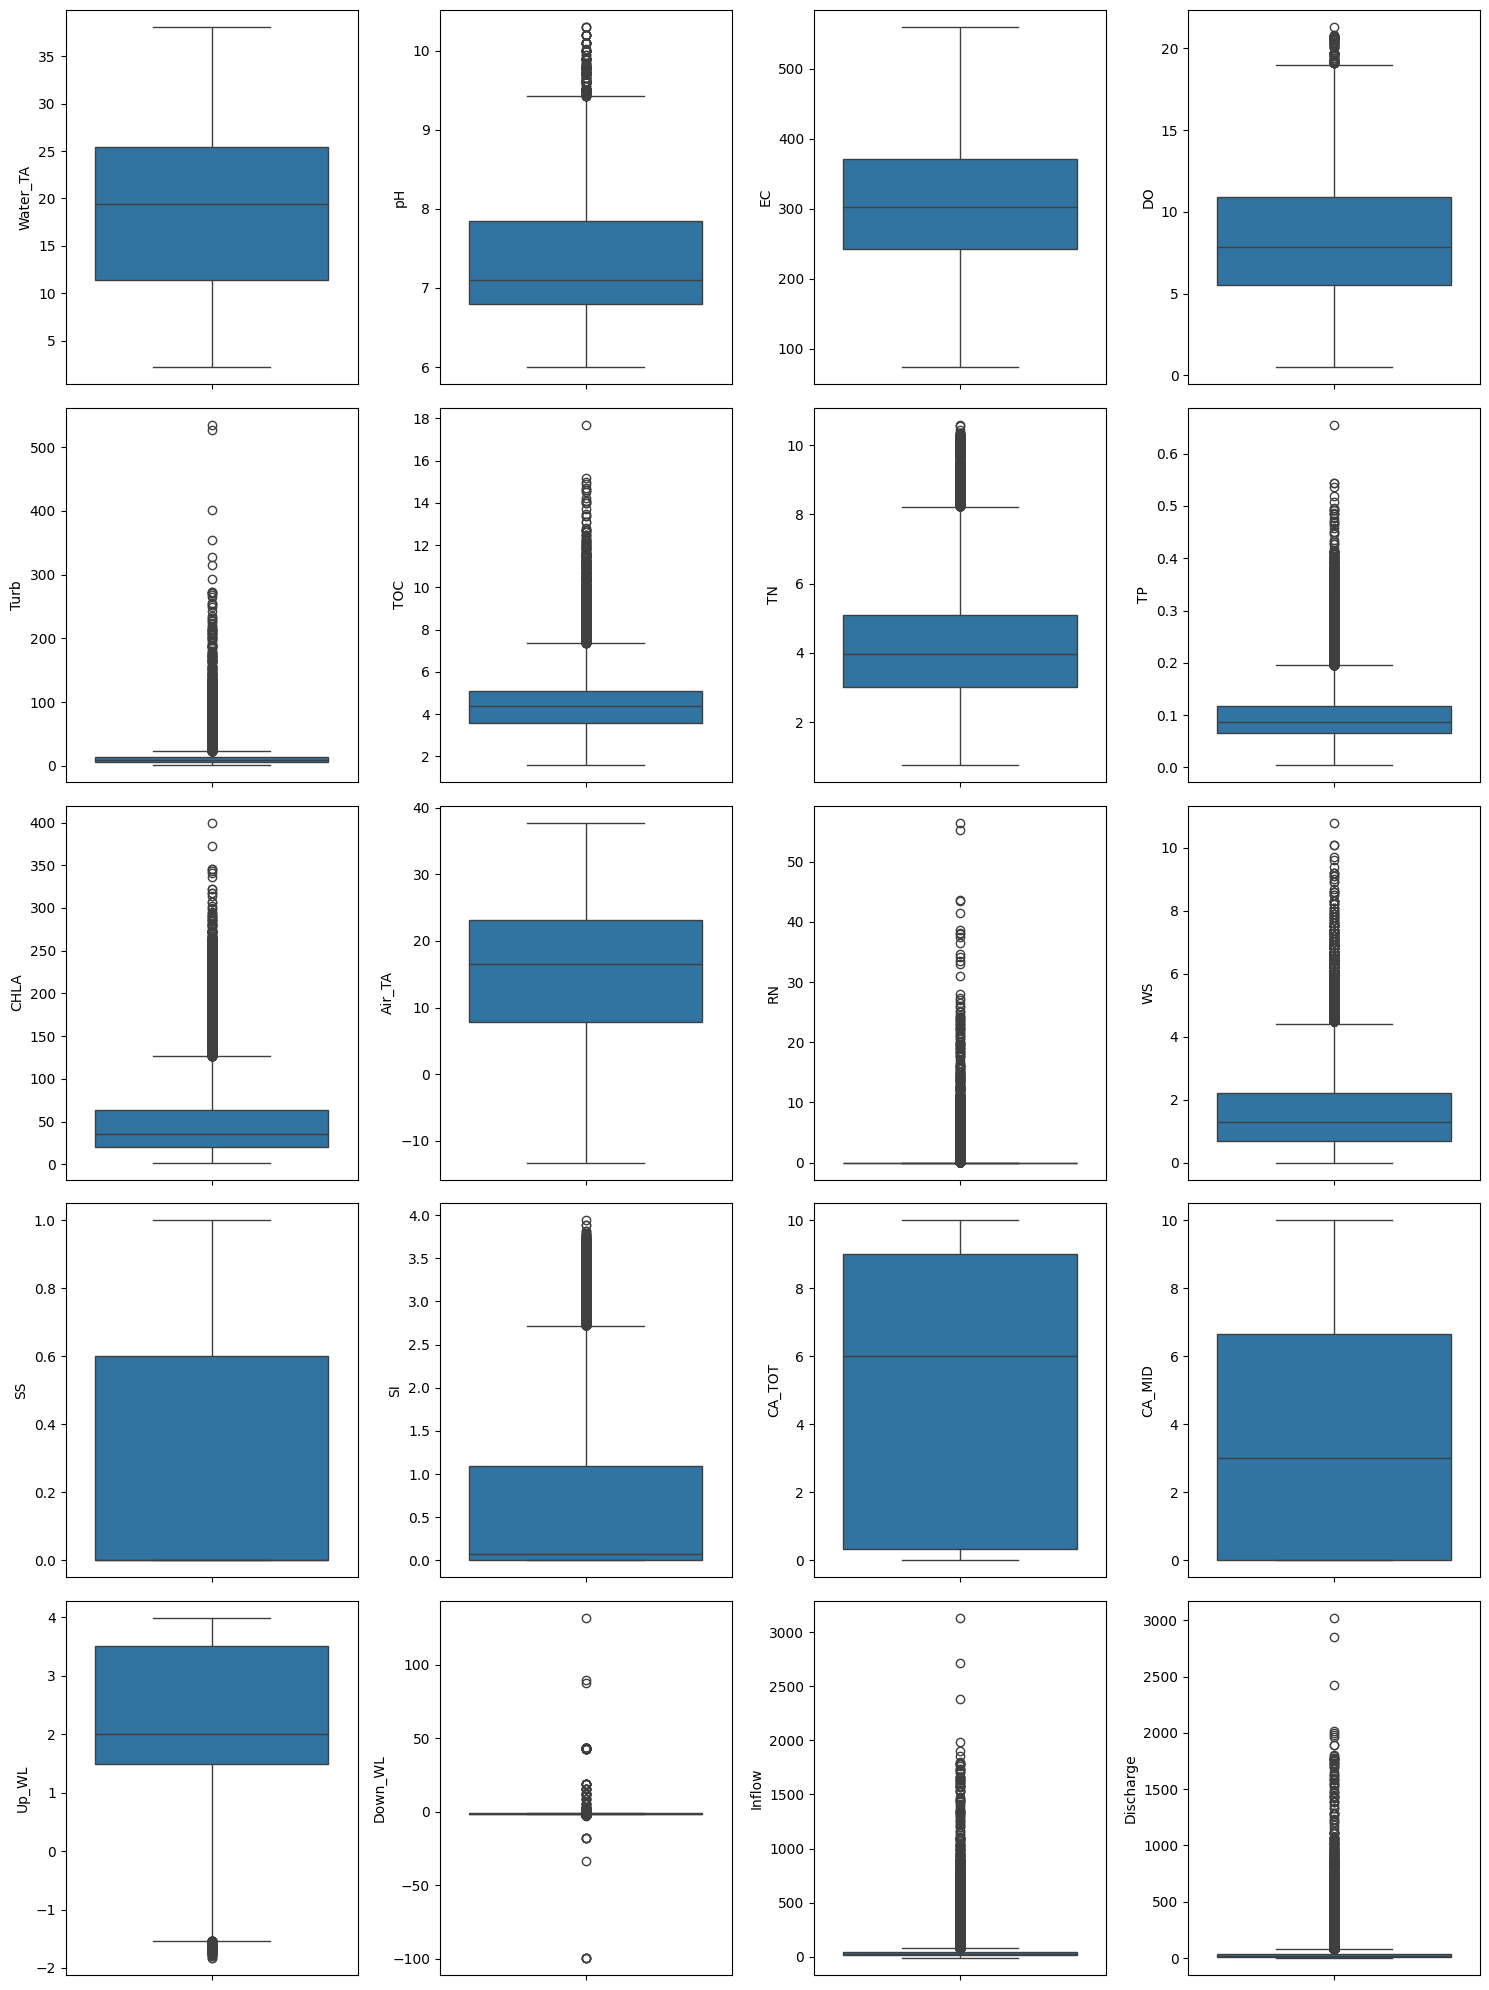

In [64]:
fig, axes = plt.subplots(5, 4, figsize=(15, 20))

for idx, col in enumerate(jsb_df.columns):
    idx_x, idx_y = divmod(idx, 4)
    
    _ = sns.boxplot(jsb_df[col], ax=axes[idx_x, idx_y])
    
plt.tight_layout()
plt.show()

### 상관관계

In [101]:
jsb_df.corr()['CHLA'].sort_values(ascending=False)

CHLA         1.000000
pH           0.650268
DO           0.601706
TOC          0.423066
TN           0.289438
EC           0.282252
Turb         0.109714
SS           0.025927
WS           0.001254
SI          -0.004134
Down_WL     -0.005394
CA_MID      -0.010849
RN          -0.029990
TP          -0.032089
CA_TOT      -0.039545
Inflow      -0.155149
Discharge   -0.156069
Up_WL       -0.243960
Air_TA      -0.269080
Water_TA    -0.315421
Name: CHLA, dtype: float64

In [71]:
jsb_df.corr()['CHLA'].abs().sort_values(ascending=False)

CHLA         1.000000
pH           0.650268
DO           0.601706
TOC          0.423066
Water_TA     0.315421
TN           0.289438
EC           0.282252
Air_TA       0.269080
Up_WL        0.243960
Discharge    0.156069
Inflow       0.155149
Turb         0.109714
CA_TOT       0.039545
TP           0.032089
RN           0.029990
SS           0.025927
CA_MID       0.010849
Down_WL      0.005394
SI           0.004134
WS           0.001254
Name: CHLA, dtype: float64

**설명**

- 도시의 호수, 하수처리장 관련 저장소의 성격과 유사
- pH, DO, CHLA 관계가 일관성 있음.
- 관련 논문 참고
    - ./papers/2wcm2024-185-189.pdf
    - ./papers/wallace2016.pdf

연도별로 1주일 단위로 선그래프를 그린다.

**pH vs. CHLA**

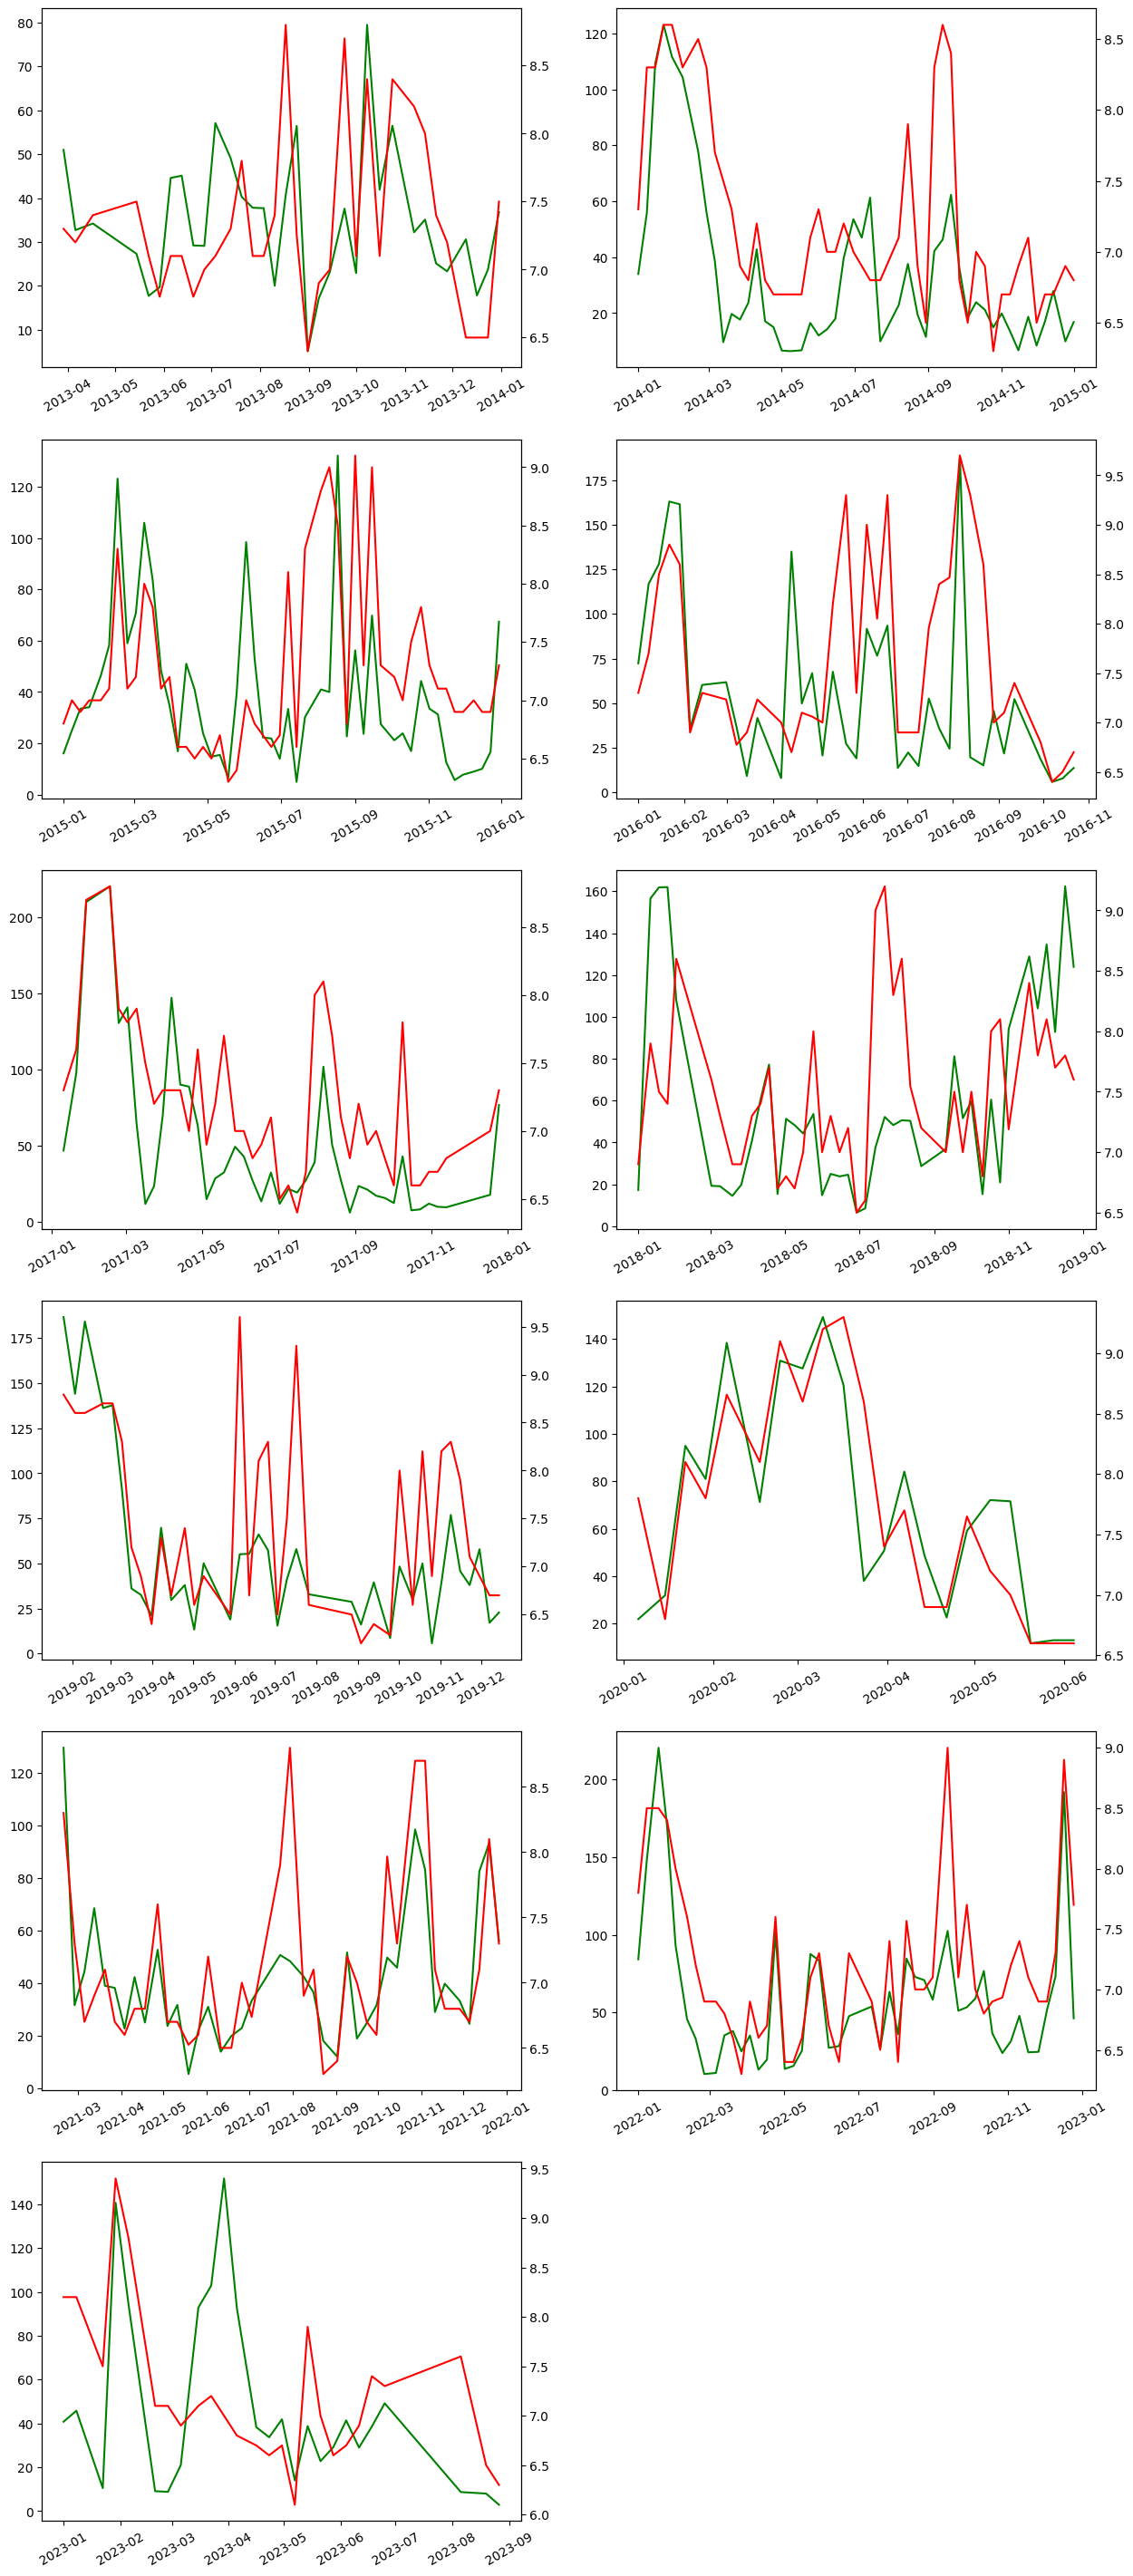

In [121]:
fig, axes = plt.subplots(6, 2, figsize=(15, 36))

idx = 0
for year in range(2013, 2024):
    idx_x, idx_y = divmod(idx, 2)
    
    start = f"{year}-01-01" 
    end = f"{year}-12-31" 

    period = 24 * 7

    sjb_yearly = jsb_df.loc[start:end].iloc[::period]

    # fig, ax1 = plt.subplots()
    ax1 = axes[idx_x, idx_y]
    ax2 = ax1.twinx()

    ax1.plot(sjb_yearly.index, sjb_yearly['CHLA'], color = 'green')
    ax2.plot(sjb_yearly.index, sjb_yearly['pH'], color = 'red')
    
    ax1.tick_params(axis='x', labelrotation=30)
    
    idx += 1

fig.delaxes(axes[5][1])
plt.show()

**DO vs. CHLA**

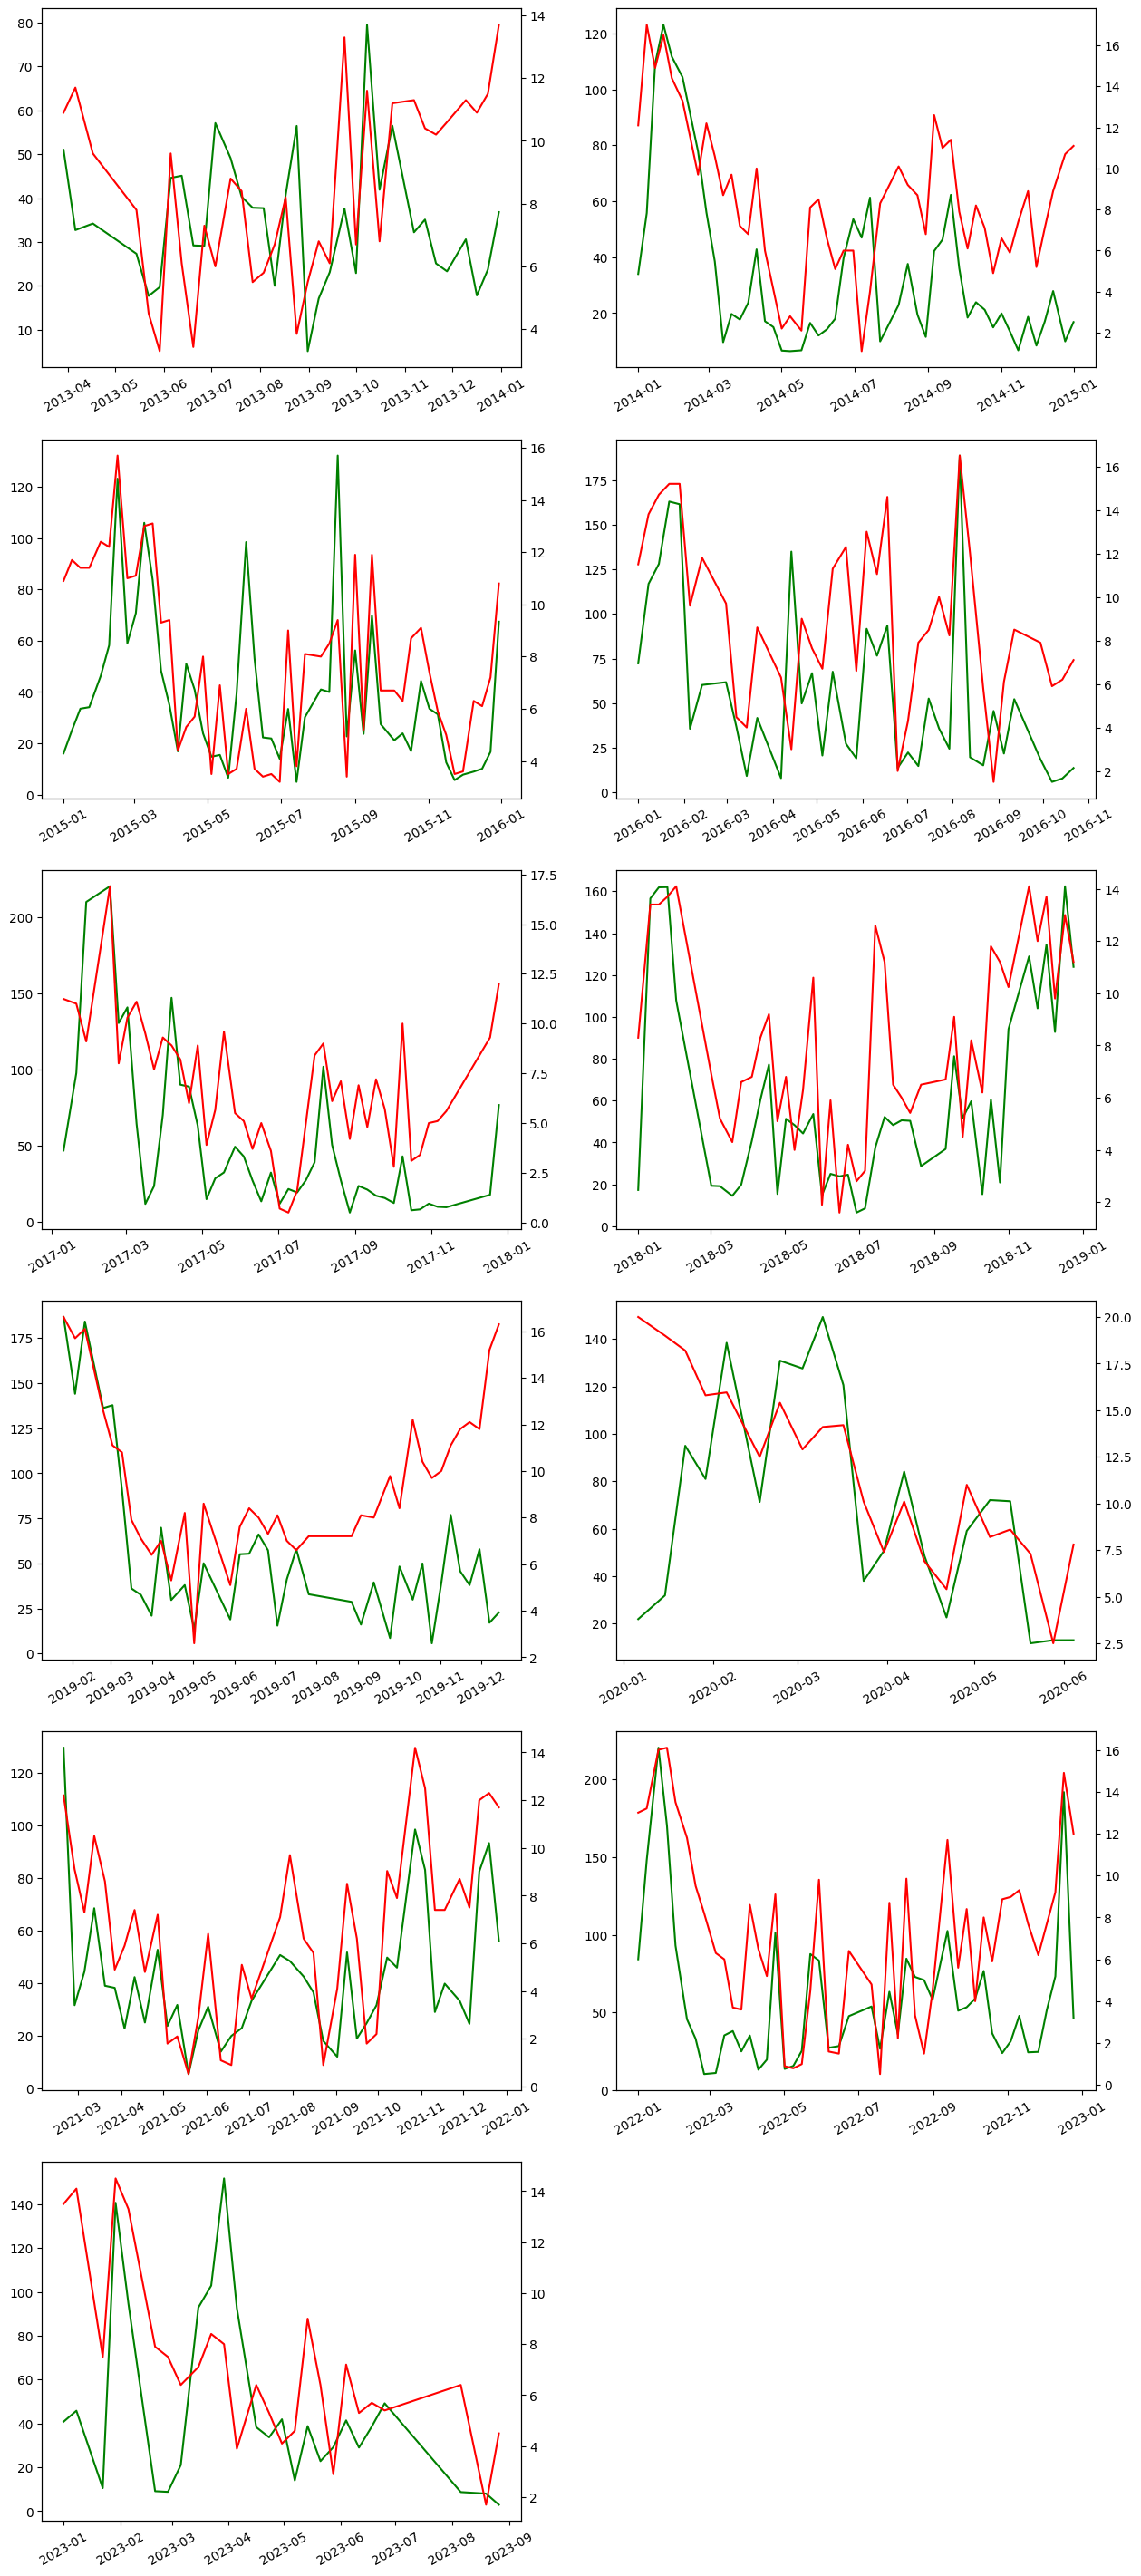

In [122]:
fig, axes = plt.subplots(6, 2, figsize=(15, 36))

idx = 0
for year in range(2013, 2024):
    idx_x, idx_y = divmod(idx, 2)
    
    start = f"{year}-01-01" 
    end = f"{year}-12-31" 

    period = 24 * 7

    sjb_yearly = jsb_df.loc[start:end].iloc[::period]

    # fig, ax1 = plt.subplots()
    ax1 = axes[idx_x, idx_y]
    ax2 = ax1.twinx()

    ax1.plot(sjb_yearly.index, sjb_yearly['CHLA'], color = 'green')
    ax2.plot(sjb_yearly.index, sjb_yearly['DO'], color = 'red')
    
    ax1.tick_params(axis='x', labelrotation=30)
    
    idx += 1

fig.delaxes(axes[5][1])
plt.show()

**TOC vs. CHLA**

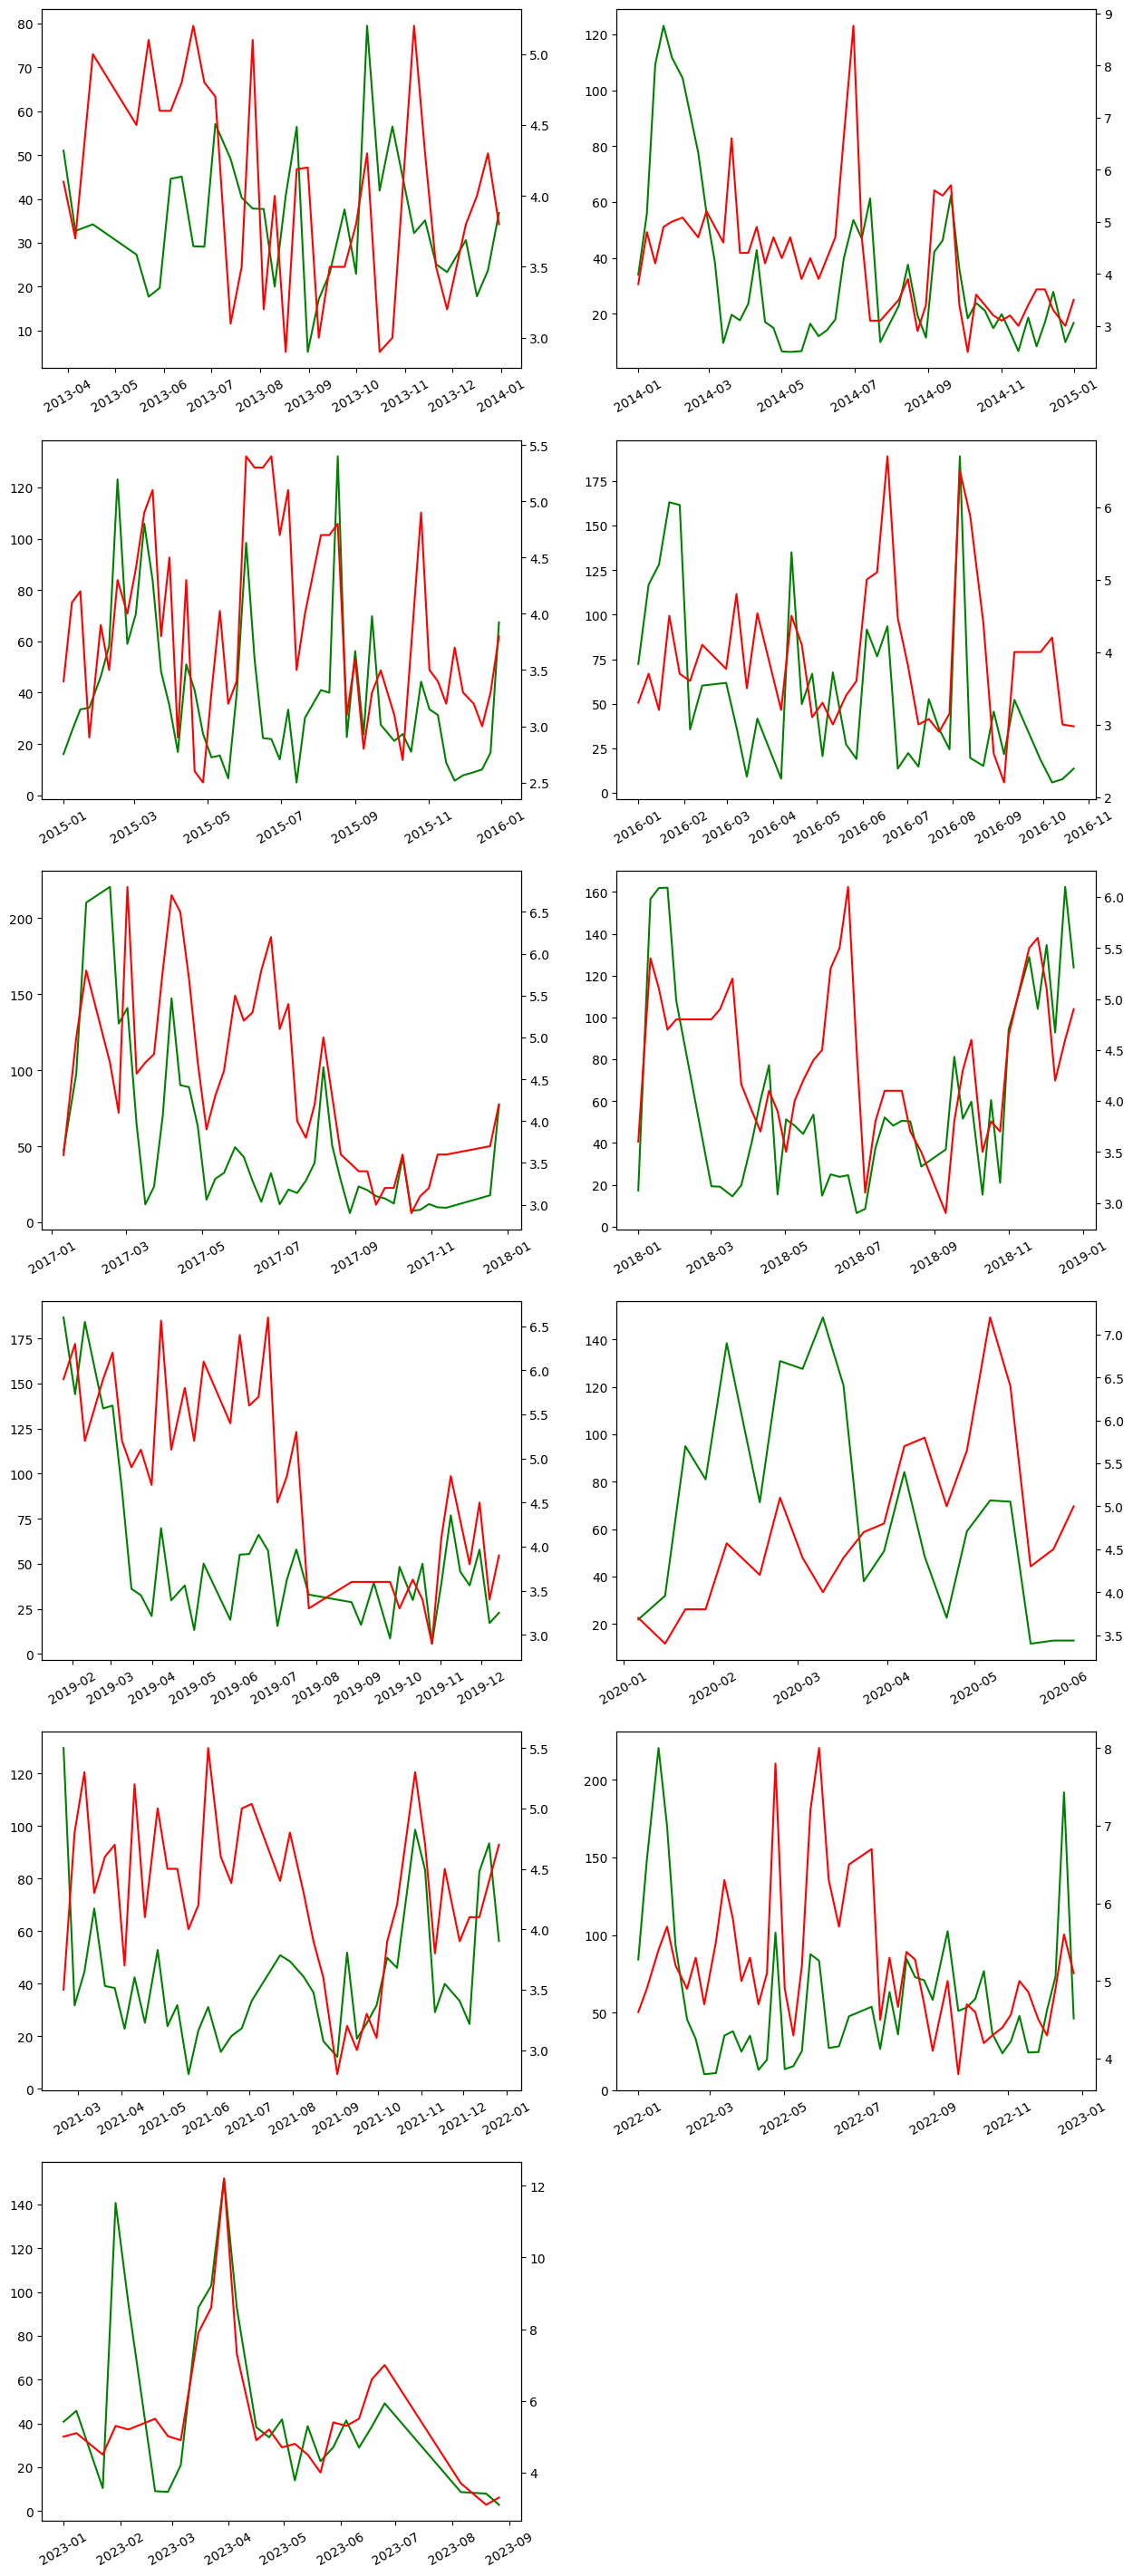

In [123]:
fig, axes = plt.subplots(6, 2, figsize=(15, 36))

idx = 0
for year in range(2013, 2024):
    idx_x, idx_y = divmod(idx, 2)
    
    start = f"{year}-01-01" 
    end = f"{year}-12-31" 

    period = 24 * 7

    sjb_yearly = jsb_df.loc[start:end].iloc[::period]

    # fig, ax1 = plt.subplots()
    ax1 = axes[idx_x, idx_y]
    ax2 = ax1.twinx()

    ax1.plot(sjb_yearly.index, sjb_yearly['CHLA'], color = 'green')
    ax2.plot(sjb_yearly.index, sjb_yearly['TOC'], color = 'red')
    
    ax1.tick_params(axis='x', labelrotation=30)
    
    idx += 1

fig.delaxes(axes[5][1])
plt.show()

**Water_TA vs. CHLA**

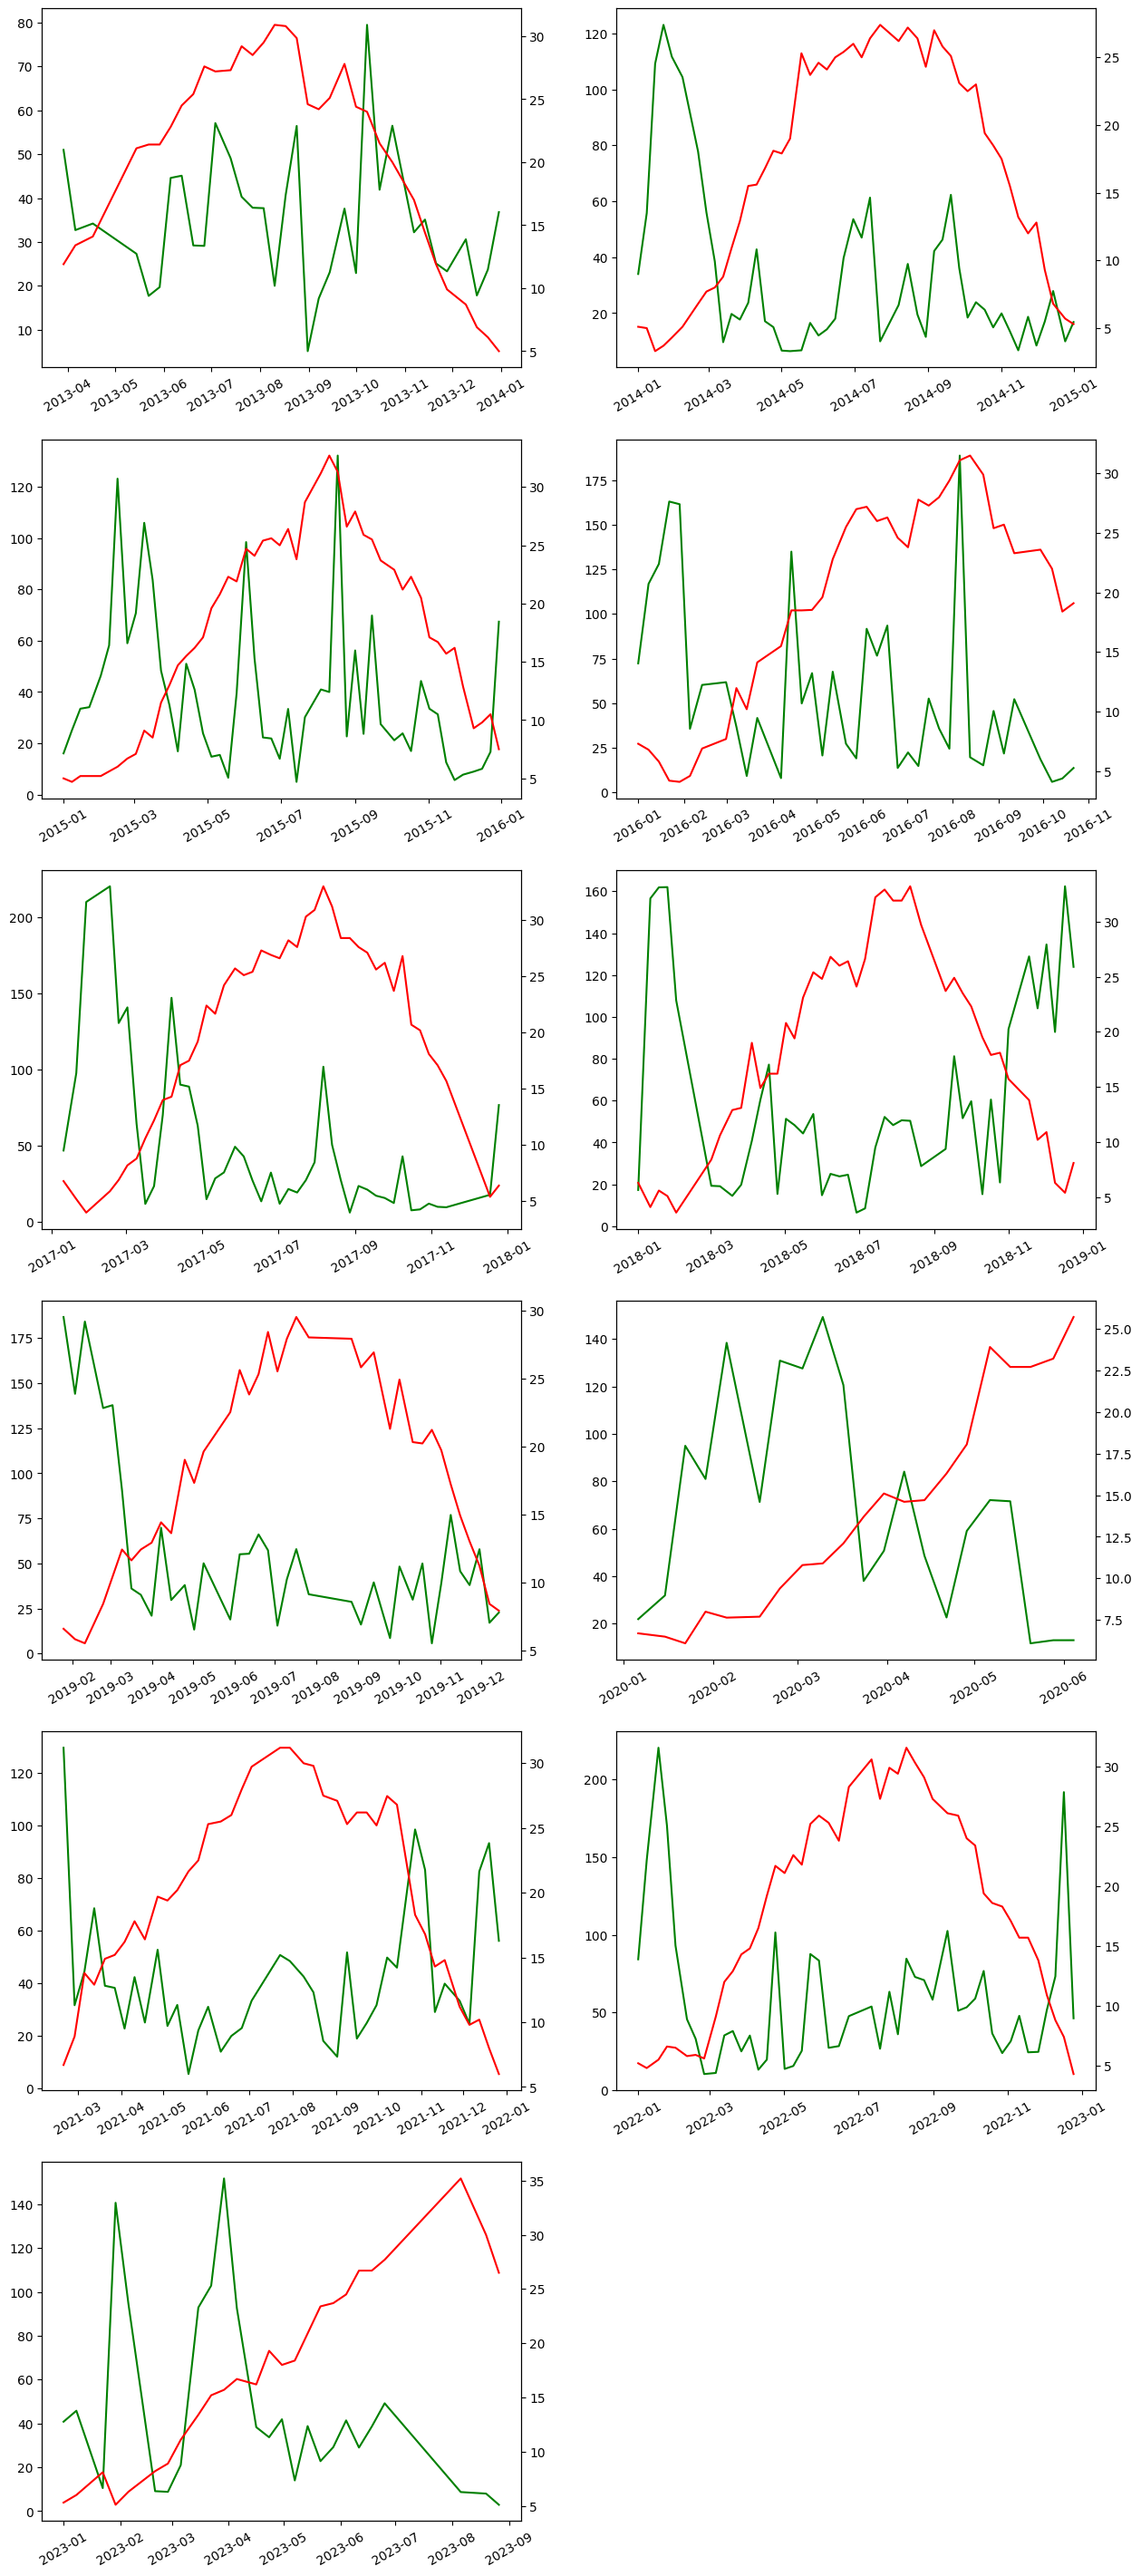

In [124]:
fig, axes = plt.subplots(6, 2, figsize=(15, 36))

idx = 0
for year in range(2013, 2024):
    idx_x, idx_y = divmod(idx, 2)
    
    start = f"{year}-01-01" 
    end = f"{year}-12-31" 

    period = 24 * 7

    sjb_yearly = jsb_df.loc[start:end].iloc[::period]

    # fig, ax1 = plt.subplots()
    ax1 = axes[idx_x, idx_y]
    ax2 = ax1.twinx()

    ax1.plot(sjb_yearly.index, sjb_yearly['CHLA'], color = 'green')
    ax2.plot(sjb_yearly.index, sjb_yearly['Water_TA'], color = 'red')
    
    ax1.tick_params(axis='x', labelrotation=30)
    
    idx += 1

fig.delaxes(axes[5][1])
plt.show()